# 기본 설정

In [107]:
import glob
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

In [108]:
# seed 설정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore


# train, test 분리

In [6]:
# 이미지가 있는 폴더 경로와 분리하여 저장할 폴더 경로
image_folder = "Pokemon_1stGen/train"
output_folder = "Pokemon_1stGen/test"

# 각 레이블의 10% 이미지를 분리하여 저장할 폴더를 생성합니다.
os.makedirs(output_folder, exist_ok=True)

# 이미지 파일 확장자
extensions = ['.jpg', '.jpeg', '.png']

# 이미지 파일을 분리하여 저장하는 함수
def split_images(image_folder, output_folder):
    # 이미지 폴더 내의 레이블 폴더들을 탐색합니다.
    for label_folder in os.listdir(image_folder):
        label_folder_path = os.path.join(image_folder, label_folder)
        if os.path.isdir(label_folder_path):
            # 레이블 폴더 내의 이미지 파일들을 탐색합니다.
            image_files = [file for file in os.listdir(label_folder_path) if os.path.splitext(file)[1].lower() in extensions]
            num_images = len(image_files)
            num_split = max(1, int(num_images * 0.15))  # 레이블별 10% 이미지 개수
            split_images = random.sample(image_files, num_split)  # 이미지 파일을 무작위로 선택합니다.

            # 선택된 이미지 파일을 분리하여 저장합니다.
            for image_file in split_images:
                image_path = os.path.join(label_folder_path, image_file)
                image = Image.open(image_path)
                
                output_label_folder = os.path.join(output_folder, label_folder)
                os.makedirs(output_label_folder, exist_ok=True)
                output_image_path = os.path.join(output_label_folder, image_file)
                try:
                    image.save(output_image_path)
                except:
                    image = image.convert('RGB')
                    image.save(output_image_path)
                os.remove(image_path)
# 이미지 분리 함수를 호출하여 실행합니다.
split_images(image_folder, output_folder)


In [7]:
# device 확인 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [109]:
# image 전체 개수 확인
train = "C:/Users/user/ryong/deep/Pokemon_1stGen/train/**/*"
test =  "C:/Users/user/ryong/deep/Pokemon_1stGen/test/**/*"
print('train 이미지 개수:', len(glob.glob(train)))
print('test 이미지 개수:', len(glob.glob(test)))

train 이미지 개수: 9167
test 이미지 개수: 1526


### 이미지 normalization을 위한 dataset 구성

In [125]:
# local에 저장된 이미지들로 train dataset구성
train_dataset = ImageFolder(root="Pokemon_1stGen/train",                   
                      transform=transforms.Compose([
                          transforms.ToTensor()]))

# local에 저장된 이미지들로 test dataset구성
test_dataset = ImageFolder(root="Pokemon_1stGen/test",                   
                      transform=transforms.Compose([
                          transforms.ToTensor()]))
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 9131
    Root location: Pokemon_1stGen/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1526
    Root location: Pokemon_1stGen/test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [40]:
# image normaliztion을 위한 각 채널 별 평균 및 표준편차 계산
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

mean_, std_ = calculate_norm(train_dataset)
print(f'train 평균(R,G,B): {mean_}\ntrain 표준편차(R,G,B): {std_}')
mean_, std_ = calculate_norm(test_dataset)
print(f'test 평균(R,G,B): {mean_}\ntest 표준편차(R,G,B): {std_}')

train 평균(R,G,B): (0.6242275, 0.6191041, 0.5806922)
train 표준편차(R,G,B): (0.2508186, 0.24027368, 0.24968527)
test 평균(R,G,B): (0.6172296, 0.6139809, 0.57699025)
test 표준편차(R,G,B): (0.2497807, 0.23995584, 0.24963577)


###  train, test dataset 및 data loader 생성

In [110]:
# local에 저장된 이미지들로 train dataset구성
# 여러 데이터 증강기법 적용
train_dataset = ImageFolder(root="Pokemon_1stGen/train",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.RandomCrop(216),
#                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#                           transforms.RandomRotation(degrees=(-20, 20), interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
                          transforms.RandomHorizontalFlip(0.8),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6242275, 0.6191041, 0.5806922), (0.2508186, 0.24027368, 0.24968527))
                      ]))

# local에 저장된 이미지들로 test dataset구성
test_dataset = ImageFolder(root="Pokemon_1stGen/test",                   
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
#                           transforms.Normalize((0.6172296, 0.6139809, 0.57699025), (0.2497807, 0.23995584, 0.24963577))
                      ]))
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 9131
    Root location: Pokemon_1stGen/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(216, 216), padding=None)
               RandomHorizontalFlip(p=0.8)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1526
    Root location: Pokemon_1stGen/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [111]:
# class개수 확인
class_num = len(test_dataset.classes)
class_num

149

In [112]:
# train, test Data Loader 생성 
batch_size = 16
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=False,)

In [113]:
# image, lable shape 확인
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([16, 3, 216, 216]), torch.Size([16]))

### 이미지 확인

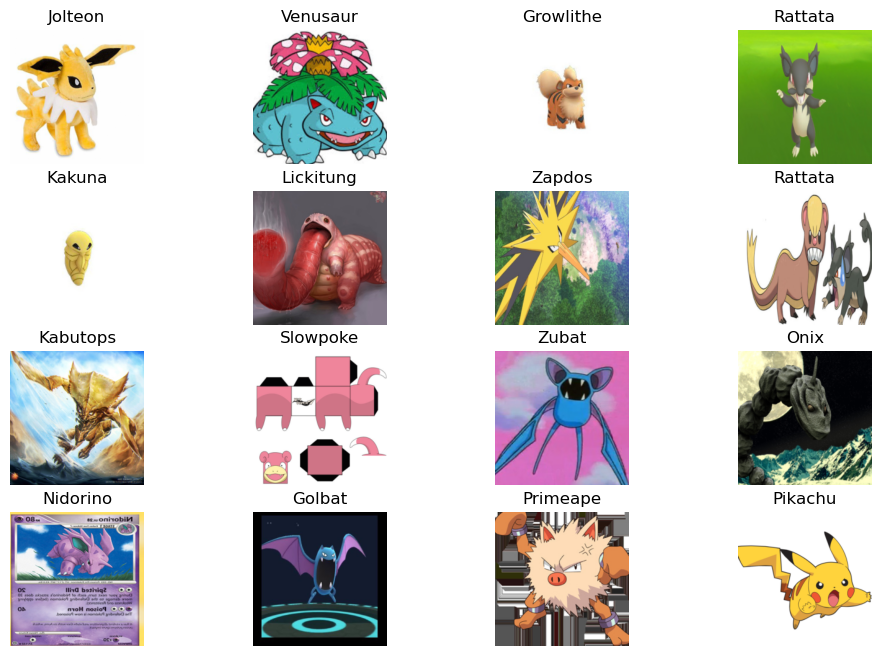

In [114]:
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}
figure = plt.figure(figsize=(12, 8))
cols, rows = 4, 4

# 이미지 확인
for i in range(1, cols * rows + 1):
    img, label = images[i - 1], labels[i - 1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

### training을 위한 준비

In [115]:
# early stopping 
# patience 동안 delta값 만큼 loss가 개선되지 않으면 훈련종료 

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [116]:
def model_train(model, data_loader, criterion, optimizer, device, scheduler=None):
    # 훈련모드(Gradient 업데이트)
    model.train()
    # loss와 accuracy 계산을 위한 변수.
    running_loss = 0
    corr = 0

    # mini-batch 
    for img, lbl in tqdm(data_loader):
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, lbl)
        loss.backward()
        optimizer.step()
        _, pred = output.max(dim=1) # max index를 반환
        corr += pred.eq(lbl).sum().item()  # 정확히 맞춘 경우 계산. 
        
        # loss 값은 1개 배치의 평균 loss, img.size(0)은 batch size
        # loss  * img.size(0)  -> 1개 배치의 전체 loss
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출
        running_loss += loss.item() * img.size(0)
        
    scheduler.step() 
    accuracy = corr / len(data_loader.dataset) # 평균 정확도
    loss = running_loss / len(data_loader.dataset) # 평균 loss
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
 
    return loss, accuracy



In [117]:
def model_evaluate(model, data_loader, criterion, device):
    # 평가모드
    model.eval()
    with torch.no_grad(): # Gradient 업데이트 방지
        running_loss = 0
        corr = 0
        
        # 배치별 evaluation
        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)   
            output = model(img)
            _, pred = output.max(dim=1) # max index를 반환
            corr += torch.sum(pred.eq(lbl)).item() # 정확히 맞춘 경우 계산. 
            
            # loss 값은 1개 배치의 평균 loss, img.size(0)은 batch size
            # loss  * img.size(0)  -> 1개 배치의 전체 loss
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출
            running_loss += criterion(output, lbl).item() * img.size(0)
        accuracy = corr / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(accuracy)       

        return loss, accuracy

### pretrained 모델을 불러와서 classifeir 교체 

In [118]:
# 불러온 pretrained 모델의 classifier 교체
# 나머지 레이어의 가중치 freezing
def change_classifier(model):
    
    for param in model.parameters():
        param.requires_grad = False
        
    try:
        print('==========before change=========\n', model.fc)
        fc_in_features = model.fc.in_features
        model.fc = torch.nn.Sequential(
            nn.Dropout(0.5, inplace=True), 
            nn.Linear(in_features=fc_in_features, out_features=class_num))   
        print('\n=========after change==========\n', model.fc)
        
    except:
        
        print('==========before change=========\n', model.classifier)
        fc_in_features = model.classifier[1].in_features
        model.classifier = torch.nn.Sequential(
            nn.Dropout(0.5, inplace=True), 
            nn.Linear(in_features=fc_in_features, out_features=class_num))
        print('\n=========after change==========\n', model.classifier)
        
    summary(model, (3,224,224), device ='cpu')
    return model


In [119]:
# EfficientNet V2_S pretrained 모델 불러오기 
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_loaded =torchvision.models.efficientnet_v2_s(weights=weights)
model= change_classifier(model_loaded)

==========before change=========
 Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

=========after change==========
 Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=149, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
    

freezing 정도에 따라 여러번 실험 결과 모든 가중치를 훈련하는 것이 가장 성능이 좋음

In [120]:
# 모든 가중치들을 훈련가능하게 변경
for param in model.parameters():
    param.requires_grad = True
summary(model, (3,224,224), device ='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [105]:
# train 준비 
def train_set(model, lr=0.00007, patience=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    learning_rate = lr
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)
    es = EarlyStopping(patience=patience, delta=0, mode='max', verbose=True)
    print(device)
    return model, criterion, optimizer, scheduler, es, device

loss 및 accuracy plot

In [89]:
def plot_loss(history):
    plt.title("Training Loss on Dataset")
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel("Epoch #")
    plt.legend(loc="lower left"), plt.grid()
    
    
def plot_acc(history):
    plt.title("Training Accuracy on Dataset")
    plt.plot(history['train_accuracy'], label='train_accuracy', marker='*')
    plt.plot(history['val_accuracy'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel("Epoch #")
    plt.legend(loc="lower left"), plt.grid()


### 모델 훈련

In [121]:
history = {'train_loss' : [], 'val_loss': [],
            'train_accuracy' :[], 'val_accuracy':[]}

seed_everything()
model, criterion, optimizer, scheduler, es, device = train_set(model)
num_epochs = 30
min_acc = -np.inf
for epoch in range(num_epochs):
    # 모델 훈련
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device, scheduler)
    # 모델 검증
    val_loss, val_acc = model_evaluate(model, test_loader, criterion, device)   
    
    es(val_acc)
    # Early Stop Check
    if es.early_stop:
        break
            
    # val_accuracy 가 개선된 경우 weights 저장
    if val_acc > min_acc:
        print(f'[INFO] val_accuracy has been improved from {min_acc:.5f} to {val_acc:.5f}. Saving Model!')
        min_acc = val_acc
        torch.save(model.state_dict(), 'BestModel_effib_v2_s_2.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

cuda


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.19it/s]


[EarlyStopping] (Update) Best Score: 0.45216
[INFO] val_accuracy has been improved from -inf to 0.45216. Saving Model!
epoch 01, loss: 4.28792, acc: 0.15453, val_loss: 3.11151, val_accuracy: 0.45216


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.19it/s]


[EarlyStopping] (Update) Best Score: 0.77064
[INFO] val_accuracy has been improved from 0.45216 to 0.77064. Saving Model!
epoch 02, loss: 2.35588, acc: 0.56336, val_loss: 1.32974, val_accuracy: 0.77064


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Update) Best Score: 0.85583
[INFO] val_accuracy has been improved from 0.77064 to 0.85583. Saving Model!
epoch 03, loss: 1.09247, acc: 0.81108, val_loss: 0.69248, val_accuracy: 0.85583


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Update) Best Score: 0.86697
[INFO] val_accuracy has been improved from 0.85583 to 0.86697. Saving Model!
epoch 04, loss: 0.58337, acc: 0.89103, val_loss: 0.53722, val_accuracy: 0.86697


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Update) Best Score: 0.88729
[INFO] val_accuracy has been improved from 0.86697 to 0.88729. Saving Model!
epoch 05, loss: 0.36576, acc: 0.92312, val_loss: 0.44010, val_accuracy: 0.88729


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.20it/s]


[EarlyStopping] (Update) Best Score: 0.88794
[INFO] val_accuracy has been improved from 0.88729 to 0.88794. Saving Model!
epoch 06, loss: 0.26374, acc: 0.93900, val_loss: 0.42710, val_accuracy: 0.88794


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.20it/s]


[EarlyStopping] (Patience) 1/10, Best: 0.88794, Current: 0.88532, Delta: 0.00262
epoch 07, loss: 0.19650, acc: 0.95203, val_loss: 0.42142, val_accuracy: 0.88532


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Update) Best Score: 0.89187
[INFO] val_accuracy has been improved from 0.88794 to 0.89187. Saving Model!
epoch 08, loss: 0.16323, acc: 0.95795, val_loss: 0.41784, val_accuracy: 0.89187


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 1/10, Best: 0.89187, Current: 0.88204, Delta: 0.00983
epoch 09, loss: 0.14664, acc: 0.96222, val_loss: 0.45065, val_accuracy: 0.88204


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.19it/s]


[EarlyStopping] (Patience) 2/10, Best: 0.89187, Current: 0.88532, Delta: 0.00655
epoch 10, loss: 0.12931, acc: 0.96419, val_loss: 0.43332, val_accuracy: 0.88532


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 3/10, Best: 0.89187, Current: 0.88598, Delta: 0.00590
epoch 11, loss: 0.11185, acc: 0.96824, val_loss: 0.47028, val_accuracy: 0.88598


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 4/10, Best: 0.89187, Current: 0.87615, Delta: 0.01573
epoch 12, loss: 0.10602, acc: 0.96857, val_loss: 0.47542, val_accuracy: 0.87615


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 5/10, Best: 0.89187, Current: 0.87615, Delta: 0.01573
epoch 13, loss: 0.09872, acc: 0.97174, val_loss: 0.46516, val_accuracy: 0.87615


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 6/10, Best: 0.89187, Current: 0.88598, Delta: 0.00590
epoch 14, loss: 0.09527, acc: 0.97185, val_loss: 0.48446, val_accuracy: 0.88598


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.19it/s]


[EarlyStopping] (Patience) 7/10, Best: 0.89187, Current: 0.88008, Delta: 0.01180
epoch 15, loss: 0.09308, acc: 0.97054, val_loss: 0.48660, val_accuracy: 0.88008


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 8/10, Best: 0.89187, Current: 0.87680, Delta: 0.01507
epoch 16, loss: 0.08756, acc: 0.97153, val_loss: 0.46684, val_accuracy: 0.87680


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 9/10, Best: 0.89187, Current: 0.87877, Delta: 0.01311
epoch 17, loss: 0.08706, acc: 0.97109, val_loss: 0.50705, val_accuracy: 0.87877


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


[EarlyStopping] (Patience) 10/10, Best: 0.89187, Current: 0.87942, Delta: 0.01245
[EarlyStop Triggered] Best Score: 0.89187


가장 정확도가 높은 가중치를 불러와서 테스트

In [122]:
model.load_state_dict(torch.load('BestModel_effib_v2_s_2.pth'))
final_loss, final_acc = model_evaluate(model, test_loader, criterion, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}') 

evaluation loss: 0.41784, evaluation accuracy: 0.89187


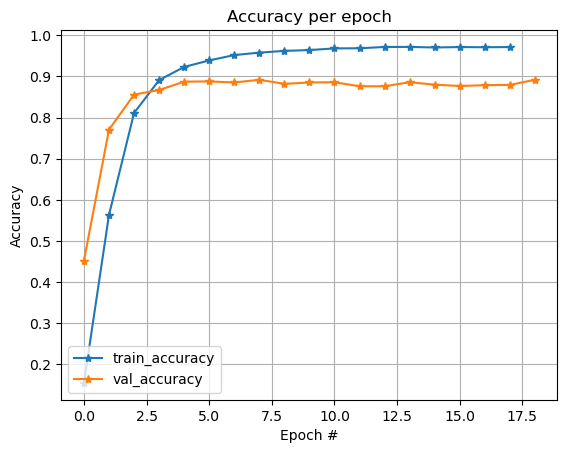

In [123]:
plot_acc(history)

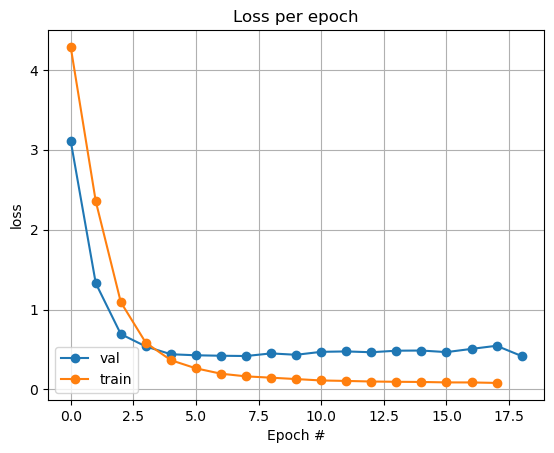

In [124]:
plot_loss(history)